In [1]:
# Importing the libraraies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Data Reading and Understanding 

In [2]:
fraud = pd.read_csv(r"C:\Users\HP\Documents\Data_Science_Course\Curriculum\Fraud detection task\Fraud.csv")

In [3]:
fraud.shape

(6362620, 11)

In [4]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# Check for null values
fraud.isnull().values.any()

False

In [6]:
#data info
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
legit = len(fraud[fraud.isFraud == 0])
frauds = len(fraud[fraud.isFraud == 1])
legit_percent = (legit / (frauds + legit)) * 100
fraud_percent = (frauds / (frauds + legit)) * 100

print("Number of Legit transactions: ", legit)
print("Number of Fraud transactions: ", frauds)
print("Percentage of Legit transactions: {:.2f}%".format(legit_percent))
print("Percentage of Fraud transactions: {:.2f}%".format(fraud_percent))

Number of Legit transactions:  6354407
Number of Fraud transactions:  8213
Percentage of Legit transactions: 99.87%
Percentage of Fraud transactions: 0.13%


These results prove that this is a highly unbalanced data as Percentage of Legit transactions= 99.87 % and Percentage of Fraud transactions= 0.13 %. SO DECISION TREES AND RANDOM FORESTS ARE GOOD METHODS FOR IMBALANCED DATA.

In [8]:
# Merchants
X = fraud[fraud['nameDest'].str.contains('M')]
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


For merchants there is no information regarding the attributes oldbalanceDest and newbalanceDest.

### Visualisation 

<AxesSubplot:>

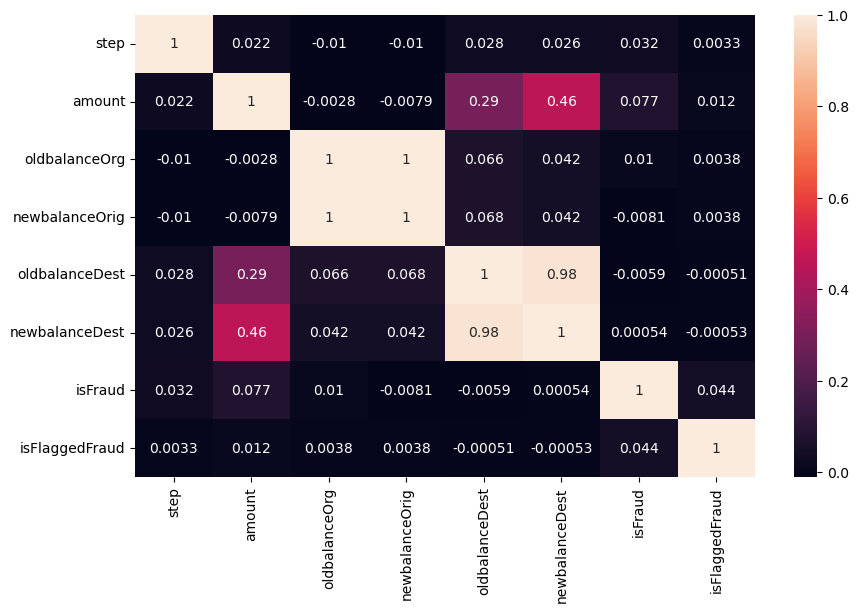

In [9]:
corr=fraud.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

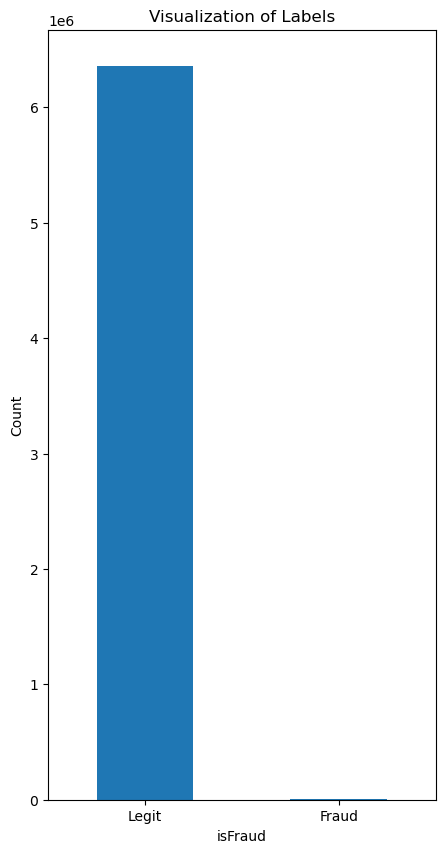

In [10]:
# legit/fraud transactions visually

plt.figure(figsize=(5,10))
labels = ["Legit", "Fraud"]
count_classes = fraud.value_counts(fraud['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [11]:
#creating a copy of original dataset to train and test models

new_fraud=fraud.copy()
new_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Label Encoding 

In [12]:
# Checking how many attributes are dtype: object

objList = new_fraud.select_dtypes(include = "object").columns
print (objList)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


There are 3 attributes with object datatype. Thus we need to label encode them in order to check Multicolinearity.

In [13]:
#Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for obj in objList:
    new_fraud[obj] = le.fit_transform(new_fraud[obj].astype(str))

print (new_fraud.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


In [14]:
new_fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [15]:
# To check for Multicolinearity
# create a dataframe that will contain all the features and their respective VIF

def calc_vif(fraud):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = fraud.columns
    vif["VIF"] = [variance_inflation_factor(fraud.values, i) for i in range(fraud.shape[1])]

    return(vif)

calc_vif(new_fraud)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


We can see that oldbalanceOrg and newbalanceOrig have too high VIF thus they are highly correlated. Similarly oldbalanceDest and newbalanceDest. Also nameDest is connected to nameOrig.

Thus combine these pairs of collinear attributes and drop the individual ones.

In [16]:
new_fraud['Actual_amount_orig'] = new_fraud.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_fraud['Actual_amount_dest'] = new_fraud.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_fraud['TransactionPath'] = new_fraud.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
new_fraud = new_fraud.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(new_fraud)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<AxesSubplot:>

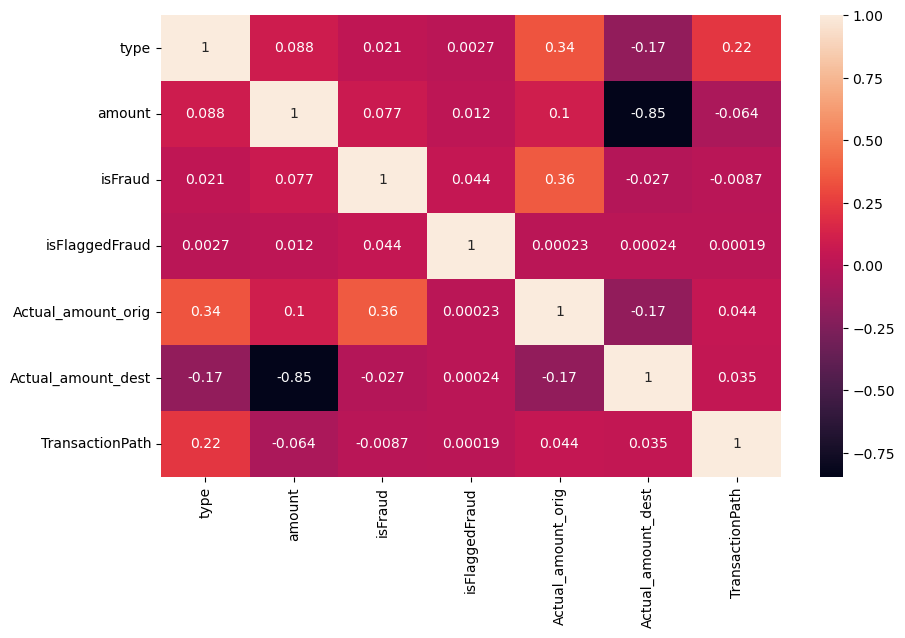

In [17]:
corr=new_fraud.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

How did you select variables to be included in the model?

Using the VIF values and correlation heatmap. We just need to check if there are any two attributes highly correlated to each other and then drop the one which is less correlated to the isFraud Attribute.

### Model Building

In [18]:
# NORMALIZING (SCALING) AMOUNT: 
# Perform Scaling

scaler = StandardScaler()
new_fraud["NormalizedAmount"] = scaler.fit_transform(new_fraud["amount"].values.reshape(-1, 1))
new_fraud.drop(["amount"], inplace= True, axis= 1)

Y = new_fraud["isFraud"]
X = new_fraud.drop(["isFraud"], axis= 1)

In [19]:
# Train-Test split(70-30)

(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 100)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


### Model training

In [20]:
# DECISION TREE

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test) * 100

In [21]:
# RANDOM FOREST

random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

###  Model evaluation

In [22]:
# Print scores of our classifiers

print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)

Decision Tree Score:  99.9243498223478
Random Forest Score:  99.9535830627425


In [25]:
# key terms of Confusion Matrix - Decision Tree

print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 1765
False Positives: 731
True Negatives: 1905577
False Negatives: 713


In [26]:
# key terms of Confusion Matrix - Random Forest

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Random Forest
True Positives: 1769
False Positives: 177
True Negatives: 1906131
False Negatives: 709


- TP(Decision Tree) ~ TP(Random Forest) so no competetion here.
- FP(Decision Tree) >> FP(Random Forest) - Random Forest has an edge
- TN(Decision Tree) < TN(Random Forest) - Random Forest is better here too
- FN(Decision Tree) ~ FN(Random Forest)

Here Random Forest looks good.

In [27]:
# confusion matrix - DT

confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)

print("----------------------------------------------------------------------------------------")

# confusion matrix - RF

confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

Confusion Matrix - Decision Tree
[[1905577     731]
 [    713    1765]]
----------------------------------------------------------------------------------------
Confusion Matrix - Random Forest
[[1906131     177]
 [    709    1769]]


In [28]:
# classification report - DT

classification_report_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("----------------------------------------------------------------------------------------")

# classification report - RF

classification_report_rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906308
           1       0.71      0.71      0.71      2478

    accuracy                           1.00   1908786
   macro avg       0.85      0.86      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

----------------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906308
           1       0.91      0.71      0.80      2478

    accuracy                           1.00   1908786
   macro avg       0.95      0.86      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786



With good precision and F1 score, Random forest comes out to be better as expected.

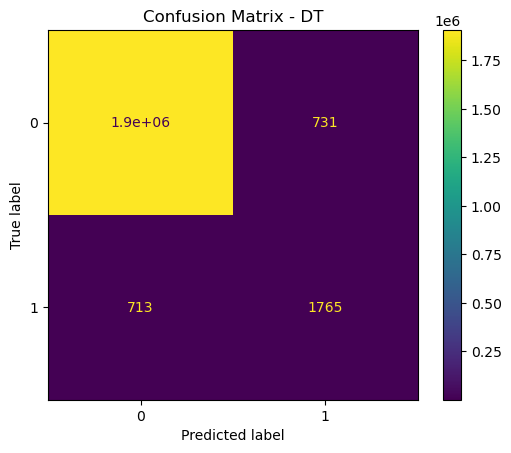

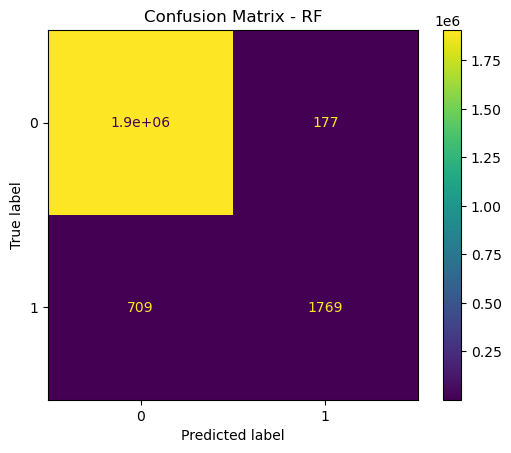

In [29]:
# visualising confusion matrix - DT

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

# visualising confusion matrix - RF
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

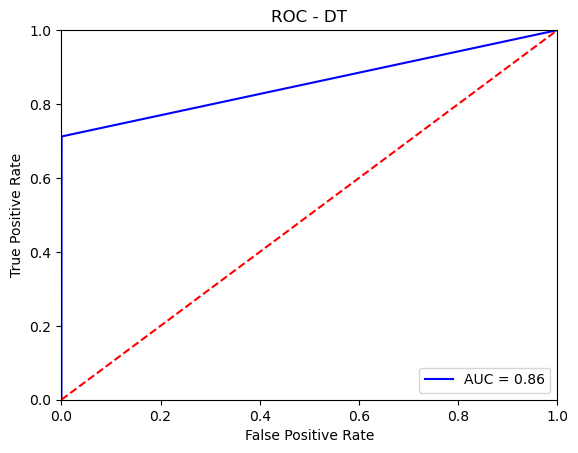

In [30]:
# AUC ROC - DT
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

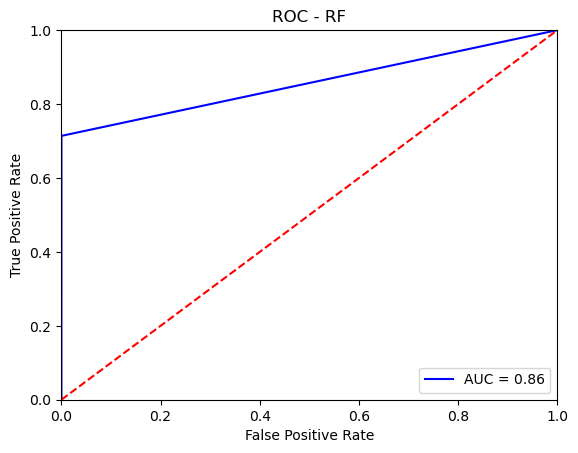

In [31]:
# AUC ROC - RF
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

THE AUC for both Decision Tree and Random Forest is equal, so both models are pretty good at what they do.

### Conclusion

We have seen that Accuracy of both Random Forest and Decision Tree is equal, although the precision of Random Forest is more.

In a fraud detection model, Precision is highly important because rather than predicting normal transactions correctly we want Fraud transactions to be predicted correctly and Legit to be left off.If either of the two reasons are not fulfiiled we may catch the innocent and leave the culprit.
This is also one of the reason why Random Forest and Decision Tree are used unstead of other algorithms.


Also the reason I have chosen this model is because of highly unbalanced dataset (Legit: Fraud :: 99.87:0.13). 
Random forest makes multiple decision trees which makes it easier (although time consuming) for model to understand the data in a simpler way since Decision Tree makes decisions in a boolean way.


Models like XGBoost, Bagging, ANN, and Logistic Regression may give good accuracy but they won't give good precision and recall values.

What are the key factors that predict fraudulent customer?

- The source of request is secured or not?
- Is the name of organisation asking for money is legit or not?
- Transaction history of vendors.

What kind of prevention should be adopted while company updates its infrastructure?

- Use smart vertified apps only.
- Browse through secured websites.
- Use secured internet connections (USE VPN).
- Keep your mobile and laptop security updated.
- Don't respond to unsolicited calls/SMS(s/E-mails.
- If you feel like you have been tricked or security compromised, contact your bank immidiately.

Assuming these actions have been implemented, how would you determine if they work?

- Bank sending E-statements.
- Customers keeping a check of their account activity.
- Always keep a log of your payments.